In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams['figure.figsize'] = fig_size
from matplotlib import rc
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Primera fase: Análisis
La fase de análisis se refiere al proceso crítico de realizar investigaciones iniciales sobre datos para descubrir patrones, detectar anomalías, probar hipótesis y verificar supuestos con la ayuda de estadísticas y representaciones gráficas. Nuestro objetivo es predecir el precio de inmuebles, dependiendo de todas las otras variables. El precio, en este caso, es nuestra variable dependiente, mientras que todas las demás características son variables independientes. 

## Obtención de datos de viviendas 
  El conjunto de datos utilizado en este proyecto proviene del dataset publicado en kaggle.com, llamado "House Sales in King County, USA". Este conjunto de datos contiene precios de venta de viviendas para el condado de King, que incluye Seattle, en Estados Unidos. Incluye casas vendidas entre mayo de 2014 y mayo de 2015.

In [3]:
df = pd.read_csv('Dataset/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Limpieza y análisis exploratorio inicial de los datos obtenidos
Después de haber recopilado toda la información, se analizarán y evaluarán los datos obtenidos para lograr elegir un subgrupo de datos para poder resolver el problema definido.

In [4]:
df.shape

(21613, 21)

In [5]:
#Tabla con los precios del dataset
precios = df['price']
precios.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [6]:
#Precio mínimo en el dataset
min_precio = np.amin(precios)
#Precio máximo en el dataset
max_precio = np.amax(precios)
#Media del precio en el dataset
media_precio = np.mean(precios)
#Mediana del precio en el dataset
mediana_precio = np.median(precios)
#Desviación estándar del precio en el dataset
std_precio = np.std(precios)

#Resultados
print("Resultados:")
print("Precio mínimo: ${}".format(min_precio))
print("Precio máximo: ${}".format(max_precio))
print("Media: ${}".format(media_precio))
print("Mediana: ${}".format(mediana_precio))
print("Desviación Estándar: ${}".format(std_precio))

Resultados:
Precio mínimo: $75000.0
Precio máximo: $7700000.0
Media: $540088.1417665294
Mediana: $450000.0
Desviación Estándar: $367118.7031813723


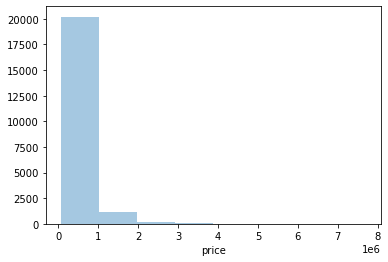

In [7]:
#Distribución del precio
sns.distplot(df['price'], kde=False, bins=8)

### Correlacion entre las variables y precio
Tener demasiadas funciones en un modelo no siempre es algo bueno porque puede causar un sobreajuste y resultados peores cuando queremos predecir valores para un nuevo conjunto de datos. Por lo tanto, si una característica no mejora mucho su modelo, no agregarlo puede ser una mejor opción.

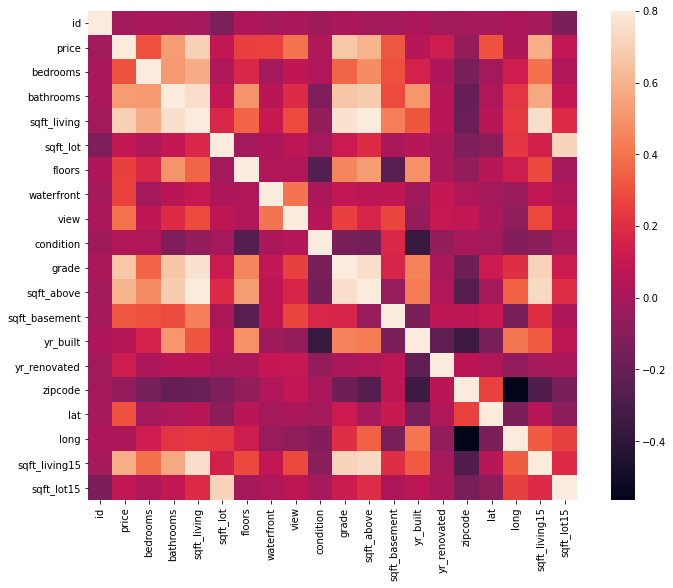

In [8]:
#Matriz de correlacion
matcorr = df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(matcorr, vmax = .8, square = True)

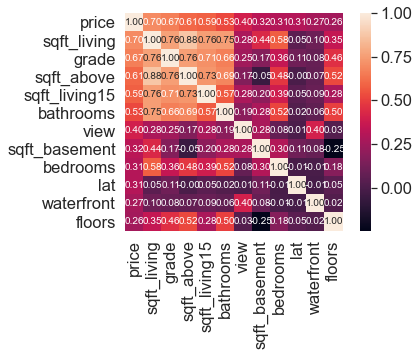

In [9]:
#Primeras 12 variables mas correlacionadas
n = 12 #numero de variables a utilizar para la matriz
col = matcorr.nlargest(n, 'price')['price'].index
cm = np.corrcoef(df[col].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = col.values, xticklabels = col.values)
plt.show()

In [10]:
#Tabla con las variables mas correlacionadas con precio
mas_corr = pd.DataFrame(col)
mas_corr.columns = ['Variables mas correlacionadas']
mas_corr

,Variables mas correlacionadas
0,price
1,sqft_living
2,grade
3,sqft_above
4,sqft_living15
5,bathrooms
6,view
7,sqft_basement
8,bedrooms
9,lat


## 	Consolidación del dataset final para pruebas
Para el propósito del proyecto, el conjunto de datos se ha preprocesado de la siguiente manera:

In [11]:
#Buscando valores nulos en el dataset
nan_rows = df[df.isnull().any(1)]
nan_rows

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [12]:
#Dataset final a utilizar, con las 12 caracteristicas mas correlacionadas
dataset = df.copy().drop(['id', 'date', 'sqft_lot', 'yr_built', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'condition'], axis = 1)
dataset.head()

,price,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,sqft_living15
0,221900.0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,1340
1,538000.0,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,1690
2,180000.0,2,1.00,770,1.0,0,0,6,770,0,47.7379,2720
3,604000.0,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,1360
4,510000.0,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,1800


## Análisis exploratorio exhaustivo del dataset final
Veremos y analizaremos las relaciones existentes entre el precio y las demás características de nuestro conjunto de datos final.

### Gráficos de dispersión

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


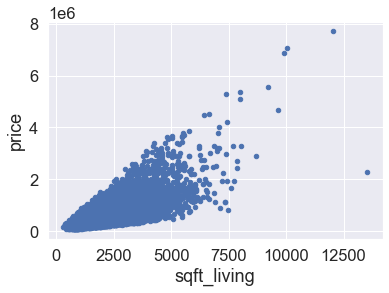

In [13]:
#Sqft_living vs precio
dataset.plot.scatter('sqft_living', 'price')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


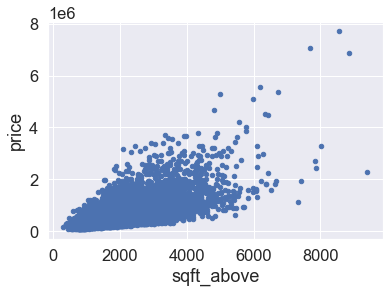

In [14]:
#Sqft_above vs precio
dataset.plot.scatter('sqft_above', 'price')

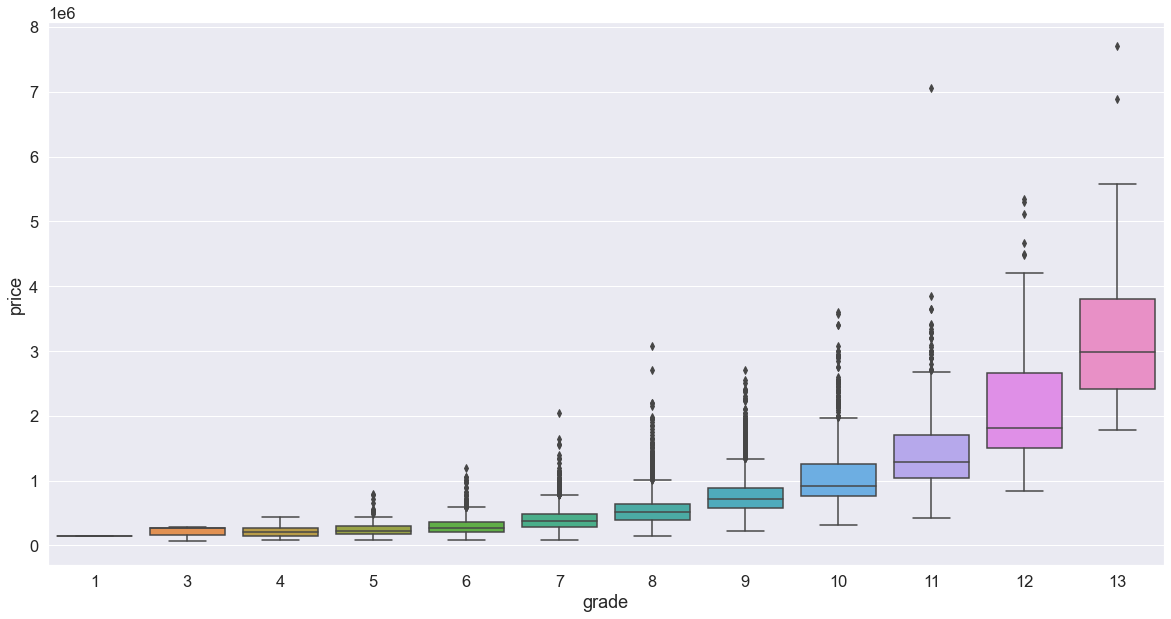

In [15]:
#Calificacion vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['grade'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


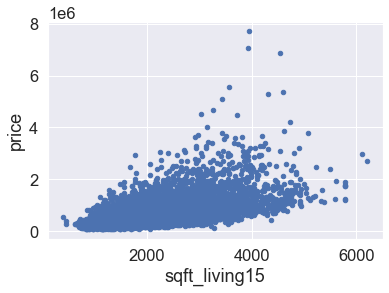

In [16]:
#Sqft_living15 vs precio
dataset.plot.scatter('sqft_living15', 'price')

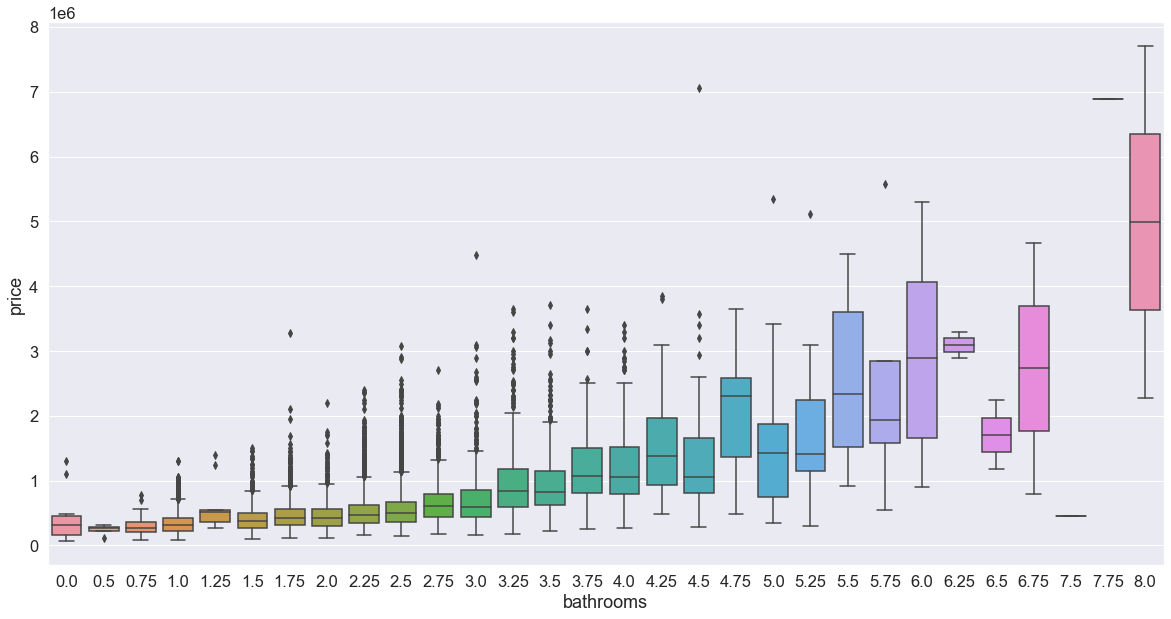

In [17]:
#Baños vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bathrooms'], y=dataset['price'])

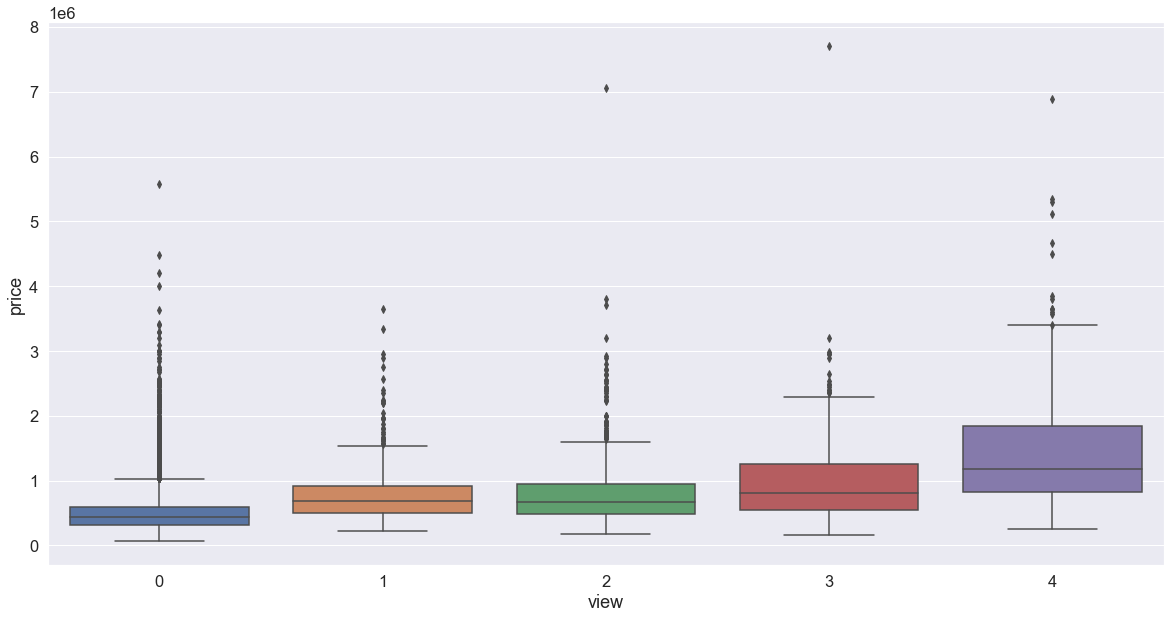

In [18]:
#Vista vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['view'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


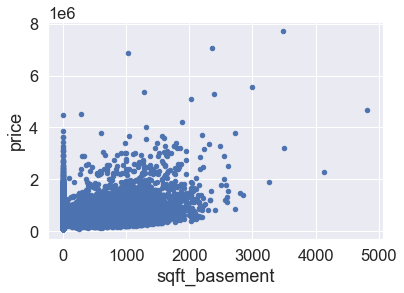

In [19]:
#Sqft_basement vs precio
dataset.plot.scatter('sqft_basement', 'price')

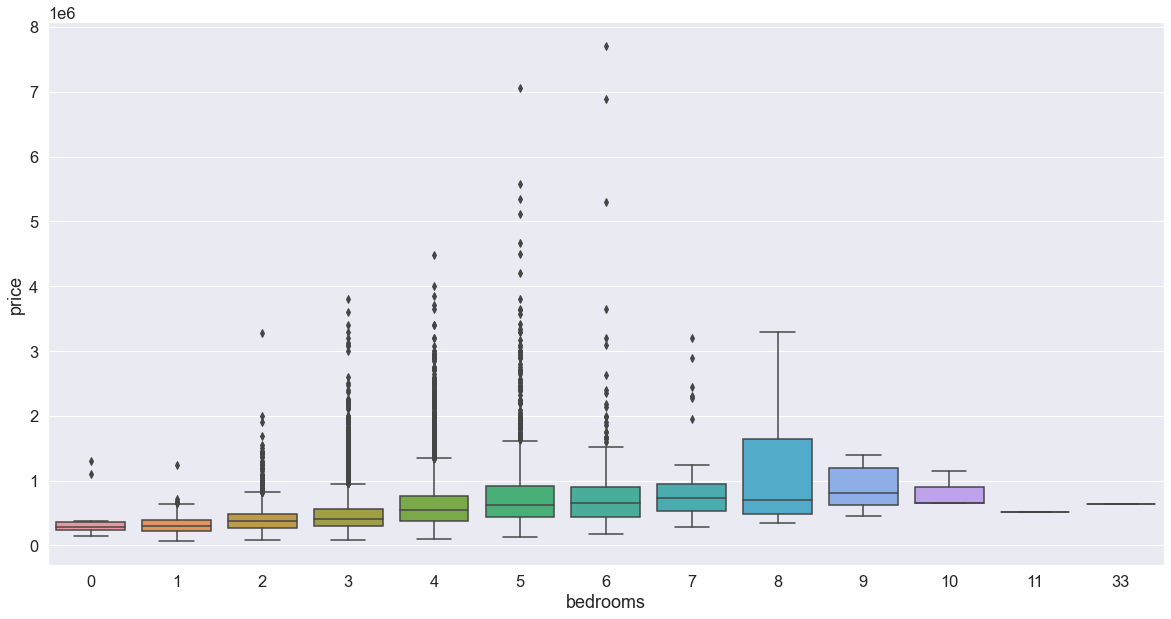

In [20]:
#Habitaciones vs precio
#df.plot.scatter('bedrooms', 'price')
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bedrooms'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


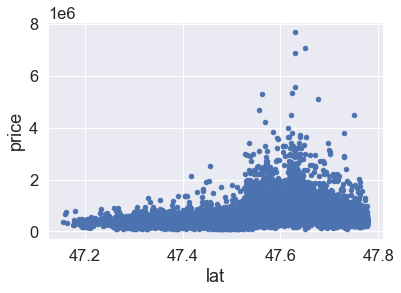

In [21]:
#Latitud vs precio
dataset.plot.scatter('lat', 'price')

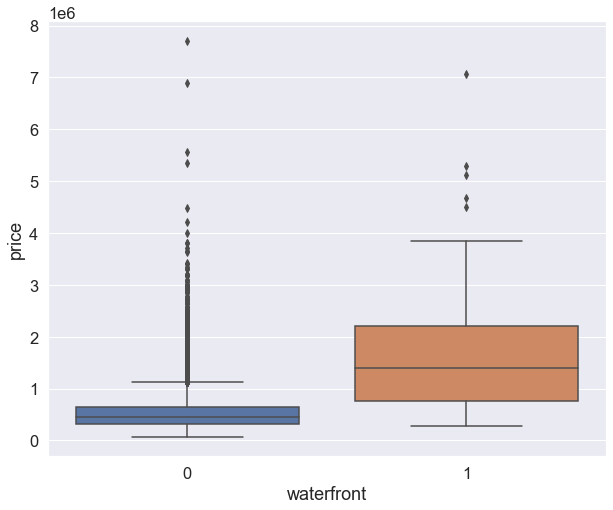

In [22]:
#Frente al mar vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['waterfront'], y=dataset['price'])

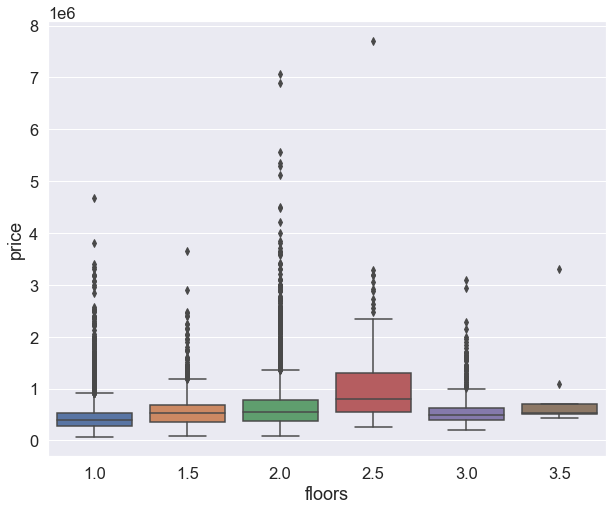

In [23]:
#Numero de pisos vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['floors'], y=dataset['price'])

# Fase 2: Diseño

## Elaboración de hipótesis de trabajo en base del estudio exploratorio previo.

## Procesamiento de información y generación de características para modelado.

### División de los datos
Para esta sección tomaremos el conjunto de datos de vivienda y los dividiremos en subconjuntos de entrenamiento y evaluación. Por lo general, los datos también se mezclan en un orden aleatorio al crear los subconjuntos de entrenamiento y prueba para eliminar cualquier sesgo en el orden del conjunto de datos.

In [24]:
#Tabla que contiene las caracteristicas de los inmuebles, sin la variable dependiente, precio, la cual intentaremos predecir
carac = dataset.drop(['price'], axis = 1)
carac.head()

,bedrooms,bathrooms,sqft_living,floors,waterfront,view,grade,sqft_above,sqft_basement,lat,sqft_living15
0,3,1.00,1180,1.0,0,0,7,1180,0,47.5112,1340
1,3,2.25,2570,2.0,0,0,7,2170,400,47.7210,1690
2,2,1.00,770,1.0,0,0,6,770,0,47.7379,2720
3,4,3.00,1960,1.0,0,0,7,1050,910,47.5208,1360
4,3,2.00,1680,1.0,0,0,8,1680,0,47.6168,1800


In [25]:
#Tabla que contiene los precios de los inmuebles en el dataset
precios = pd.DataFrame(dataset['price'])
precios.head()

,price
0,221900.0
1,538000.0
2,180000.0
3,604000.0
4,510000.0


In [26]:
#Division de las variables en entrenamiento y evaluacion
x_ent, x_eval, y_ent, y_eval = train_test_split(carac, precios, test_size=0.2, random_state = 42)

# Fase 3: Implementación
En esta tercera sección del proyecto, desarrollaremos las herramientas y técnicas necesarias para que un modelo haga una predicción. 

## Generación de modelos predictivos utilizando machine learning.
Una vez que se limpian los datos, procederemos a realizar nuestros modelos de aprendizaje automático. El precio de venta es en dólares e intentaremos predecirlo.

### Regresión Lineal
En estadísticas, regresión lineal es una aproximación para modelar la relación entre una variable escalar dependiente "Y" y una o mas variables explicativas nombradas con "X". Lo que haremos es "dibujar una recta" que nos indicará la tendencia de un conjunto de datos continuos. 

In [27]:
algoritmo = linear_model.LinearRegression()
algoritmo.fit(x_ent, y_ent)
print('Pendiente de la recta: ', algoritmo.coef_)
print('Intersección: ', algoritmo.intercept_)

Pendiente de la recta:  [[-2.45480669e+04 -7.62339274e+01 -4.27217353e+13 -3.06903416e+04
   5.84595741e+05  6.85930998e+04  8.00005899e+04  4.27217353e+13
   4.27217353e+13  6.71176621e+05  3.37092095e+00]]
Intersección:  [-32294903.95205321]


In [28]:
prediccion = algoritmo.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion))
r2 = metrics.r2_score(y_eval, prediccion)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 137691.5373343252
Error cuadrático medio: 226211.49206888923
R-cuadrado: 0.6615110992949097


In [29]:
#Tabla que contiene los resultados de las metricas de evaluacion de cada modelo
evaluacion = pd.DataFrame({'Modelo': [], 'Error medio absoluto':[], 'Error cuadrático medio':[], 'R-cuadrado':[],})
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion lineal', mae, rmse, r2]
evaluacion

,Modelo,Error medio absoluto,Error cuadrático medio,R-cuadrado
0,Regresion lineal,137691.537334,226211.492069,0.661511
